# Example 3 - Ferry Service with Deterministic Demand



Let's make life easy for this one and assume the following set up:


- A ferry (or whatever) has remaining capacity S (not C, because remaining capacity is our state variable).
- Each period, the operator can set a price to sell space at.
- The ferry faces a fixed deterministic demand given by

$$q = A e^{-kp}$$

- In a given period, the operator sets price and realizes demand. The remaining capacity they take into next period is

$$ s^{\prime} = \max\{ s - q, 0\} $$

That is, if they can't satisfy demand with the remaining space they sell nothing.

- The period payoff is 

$$ p (s - s^{\prime}) $$

## Libraries

In [1]:
import numpy as np


from markov_decision_process import TimeAugmentedMDP


import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("deep")
%matplotlib inline

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
## Parameters
A = 10
K = 0.05


def demand(price):
    # Let demand be linear in price
    # It can't be less than 0
    # q = 10 - .15*price
    q = A * np.exp(-K * price)

    # Round q to the nearest half
    q = np.round(q * 2) / 2

    return np.clip(q, 0, None)

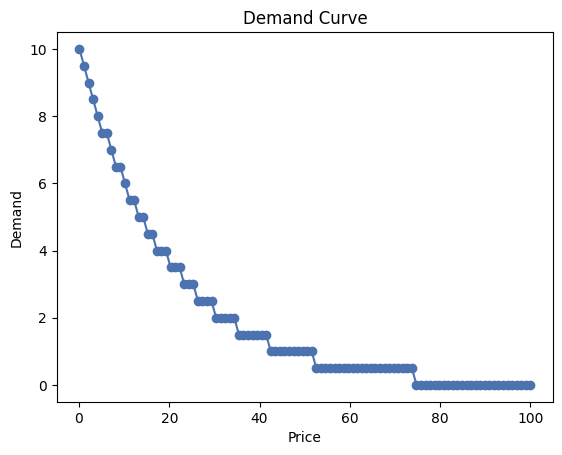

In [3]:
# Plot our demand curve

x = np.linspace(1e-1, 100, 100)
y = demand(x)

plt.scatter(x, y)
plt.plot(x, y)
plt.xlabel("Price")
plt.ylabel("Demand")
plt.title("Demand Curve")
plt.show()

In [4]:
## Important: The reason for the rounding there is because otherwise there will never be a case
## where the s_prime that's computed is actually in the state space.

## Problem Setup

Note that in this problem we have a large state and action space. To have this compute efficiently, we 
need to ensure that our transition and reward functions are vectorized; in the sense that they will accept numpy arrays/pandas colums.

In [5]:
class MDPProblem(TimeAugmentedMDP):
    def __init__(self):
        super().__init__()

        # Use a grid for the state space. We'll have max capacity be 100
        max_capacity: float = 100

        self.S: list[float] = np.linspace(0, max_capacity, 201).tolist()

        self.A: list[float] = np.linspace(1, 100, 101).tolist()

        self.T: list[int] = np.arange(20).tolist()

        return None

    def reward(
        self,
        s_prime: float,
        s: float,
        t: int,
        a: float,
    ) -> float:
        return np.clip(a * (s - s_prime), 0, None)

    def transition(
        self,
        s_prime: float,
        s: float,
        t: int,
        a: float,
    ) -> float:
        q = demand(a)
        return (s_prime == s - q).astype(int)

In [6]:
%%time
# Let's split these up to time them
mdp = MDPProblem()
mdp.solve_vectorized()

# Note we're using solve_vectorized here because we have a big grid and our
# transition/reward function is vectorized

INFO:markov_decision_process.time_augmented_mdp:State space augmented with time


INFO:markov_decision_process.time_augmented_mdp:MDP solved


CPU times: user 27.4 s, sys: 9.61 s, total: 37 s
Wall time: 37 s


In [7]:
# Note that most of the time here is spent setting up the matrices. The actual
# solve time is neglitible.

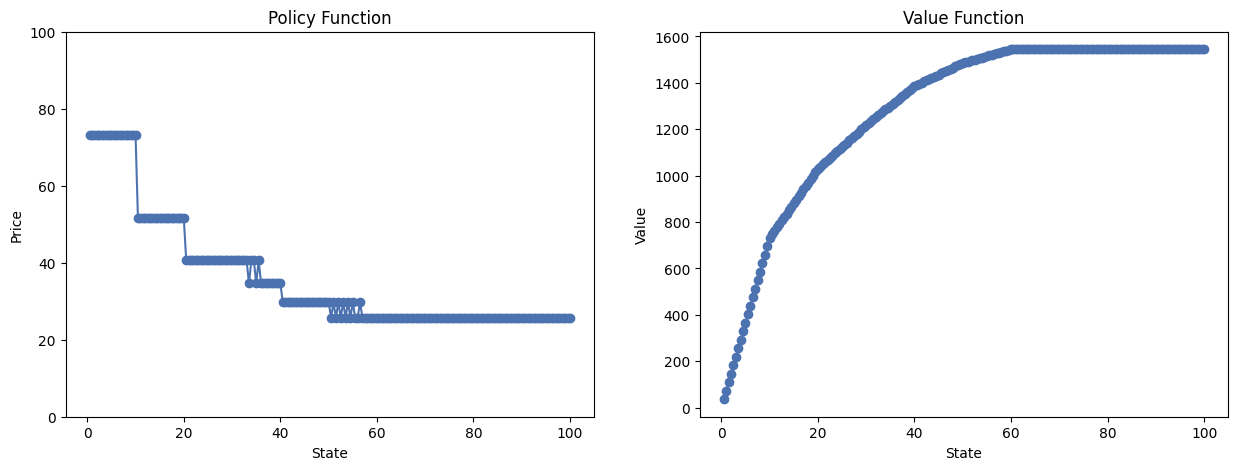

In [8]:
period = 0

x = mdp.policy_function[period].keys()
policy = mdp.policy_function[period].values()
value = mdp.value_function[period].values()

# Remove state 0
x = list(x)[1:]
policy = list(policy)[1:]
value = list(value)[1:]


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(x, policy)
ax[0].plot(x, policy)
ax[0].set_title("Policy Function")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Price")
ax[0].set_ylim(0, 100)

ax[1].scatter(x, value)
ax[1].plot(x, value)
ax[1].set_title("Value Function")
ax[1].set_xlabel("State")
ax[1].set_ylabel("Value")

plt.show()

In [9]:
# Hey! That's a monotone value function, that's good! More of the state should be better than less.

# The policy likely has those little departures from monotone because of tie breakers (two or more prices are equally good and it picks one).

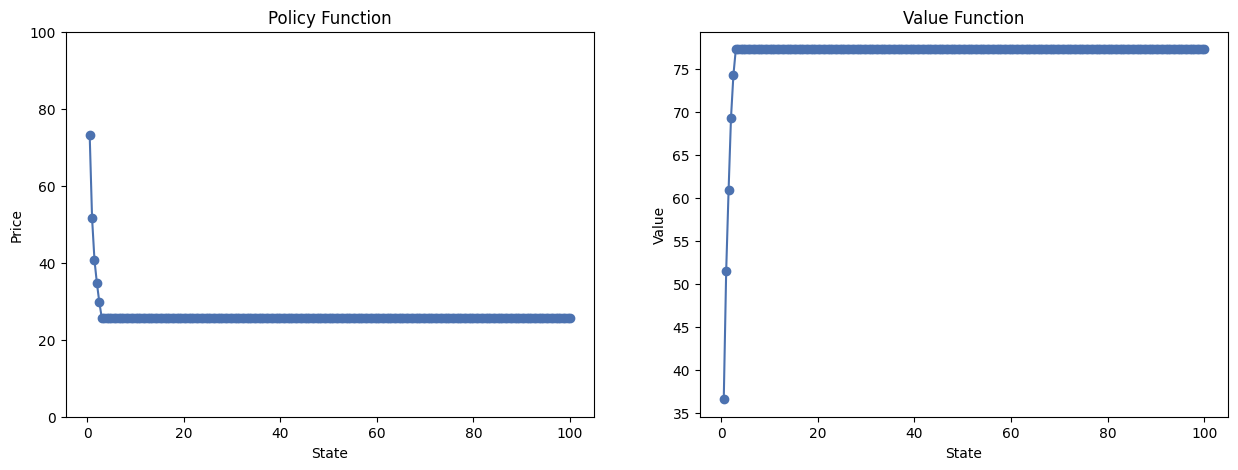

In [10]:
period = max(mdp.T) - 1

x = mdp.policy_function[period].keys()
policy = mdp.policy_function[period].values()
value = mdp.value_function[period].values()

# Remove state 0
x = list(x)[1:]
policy = list(policy)[1:]
value = list(value)[1:]


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(x, policy)
ax[0].plot(x, policy)
ax[0].set_title("Policy Function")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Price")
ax[0].set_ylim(0, 100)

ax[1].scatter(x, value)
ax[1].plot(x, value)
ax[1].set_title("Value Function")
ax[1].set_xlabel("State")
ax[1].set_ylabel("Value")

plt.show()

In [11]:
# If there's only one selling period left, then it makes sense that we should set a lower price to sell more if we have lots of spare capacity.

# When we have very little spare capacity, we should set a higher price to sell less.

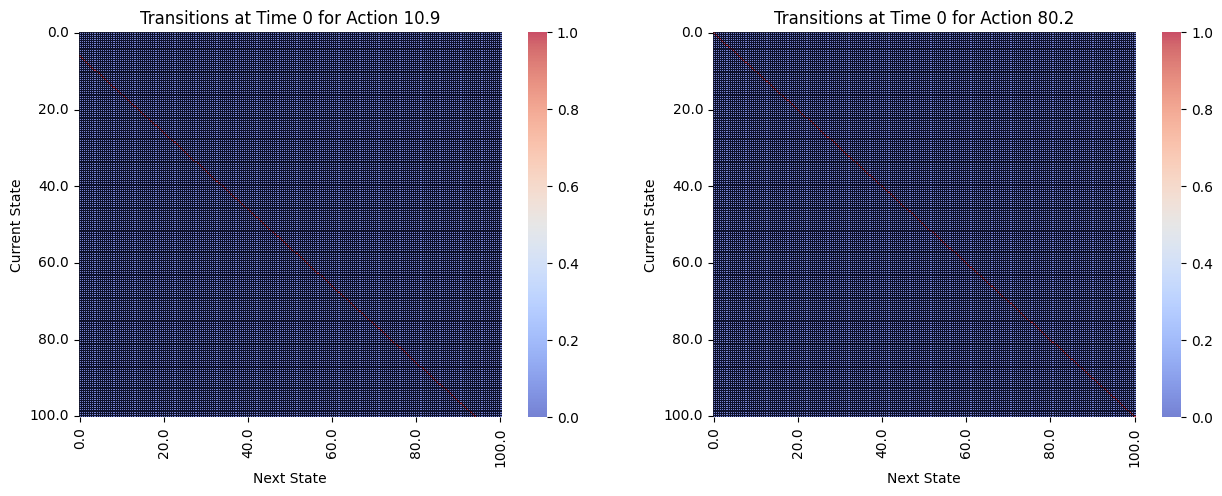

In [15]:
## Plot transitions

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

mdp.plot_matrix(matrix_type='transitions', t=0, a=mdp.A[10], ax=ax[0])
mdp.plot_matrix(matrix_type='transitions', t=0, a=mdp.A[80], ax=ax[1])


plt.show()

